<a href="https://colab.research.google.com/github/ElaYJ/Study_Deep_Learning/blob/main/Final_Project/Mask_R_CNN_workbook3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## - import

In [ ]:
import os
import glob
import time
import random
import json
import pickle
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from PIL import Image, ImageDraw
from collections import defaultdict
from tqdm import tqdm

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import warnings
warnings.filterwarnings(action='ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

src = list(files.upload().values())[0]
open('solar_util.py','wb').write(src)

Saving solar_utils.py to solar_utils (1).py


9157

In [ ]:
import solar_utils as util
util.test_print()

Import Success~!!


### configuration

In [ ]:
ROOT = "/content/drive/MyDrive/Final_Project/g25_dataset"
TRAIN_PATH = ROOT + "/train/images"
VALID_PATH = ROOT + "/valid/images"
TEST_PATH  = ROOT + "/test/images"
TRAIN_JSON = ROOT + "/train/annotations/g25_instances_train_sample.json"
VALID_JSON = ROOT + "/valid/annotations/g25_instances_valid_half.json"
TEST_JSON  = ROOT + "/test/annotations/g25_instances_test.json"

BEST_MODEL = True
BEST_MODEL_PATH = "/content/drive/MyDrive/FP/checkpoints_g25/best_model_10-7_0.2154.pth"

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

# Will be used to normalize pictures
# Normalize to resnet mean and std if True.
NORMALIZE = False
RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

BATCH_SIZE = 8

MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
LEARNING_RATE = 0.001
USE_SCHEDULER = True
NUM_EPOCHS = 10

# Confidence required for a pixel to be kept for a mask
MASK_THRESHOLD = 0.5
MASK_THRESHOLD_DICT = {1: 0.5, 2: 0.75}
MIN_SCORE_DICT = {1: 0.59, 2: 0.75, 3: 0.5}

cpu


## - dataset

### 1. custom dataset

In [ ]:
class SolarPanelDataset(Dataset):
    def __init__(self, image_dir, ann_file, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms
        # COCO
        self.coco = COCO(ann_file)
        self.ids = self.coco.getImgIds()
        self.catid_to_name = {cat['id']: cat['name'] for cat in self.coco.loadCats(self.coco.getCatIds())}

        # self.ids = list(self.coco.imgs.keys())
        # self.annotations = {ann['image_id']: [] for ann in self.coco.dataset['annotations']}
        # for ann in self.coco.dataset['annotations']:
        #     self.annotations[ann['image_id']].append(ann)

        # JSON
        # with open(ann_file, 'r') as f:
        #     self.coco = json.load(f)
        # self.ids = [img['id'] for img in self.coco['images']]
        # self.image_info = {img['id']: img for img in self.coco['images']}
        # self.annotations = {ann['image_id']: [] for ann in self.coco['annotations']}
        # for ann in self.coco['annotations']:
        #     self.annotations[ann['image_id']].append(ann)

    def __getitem__(self, index):
        img_id = self.ids[index]
        # img_info = self.image_info[img_id]
        img_info = self.coco.imgs[img_id]
        ann_info = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))

        img_path = os.path.join(self.image_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        boxes = []
        areas = []
        labels = []
        masks = [] # 한 이미지에 3개의 객체가 있으면, masks 텐서는 각각 객체에 대응하는 3개의 2D 마스크를 포함해야 함.
        for ann in ann_info:
            xmin, ymin, width, height = ann['bbox']
            boxes.append([xmin, ymin, xmin + width, ymin + height])
            areas.append(ann['area'])
            labels.append(ann['category_id'])
            segm = ann['segmentation']
            masks.append(self.convert_to_mask(segm, img.size))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8) # (N, height, width) 크기의 텐서로, N은 이미지 내 객체의 수를 의미
        # iscrowd = torch.as_tensor([ann['iscrowd'] for ann in ann_info], dtype=torch.int64)
        iscrowd = torch.zeros((len(ann_info),), dtype=torch.int64)
        image_id = torch.tensor([img_id])

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'area': areas,
            'image_id': image_id,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)

    def convert_to_mask(self, segment, image_size):
        mask = Image.new('L', image_size, 0)
        ImageDraw.Draw(mask).polygon(segment, outline=1, fill=1)
        return mask # <PIL.Image.Image image mode=L size=512x512>

### 2. transforms

In [ ]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class RandomHorizontalFlip: # x, width
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if np.random.rand() < self.prob:
            image = F.hflip(image)
            target["boxes"] = self.flip_boxes(target["boxes"], image.shape[-1])
            target["masks"] = target["masks"].flip(-1) # PIL Iamge Object
        return image, target

    def flip_boxes(self, boxes, width):
        boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
        return boxes

class RandomVerticalFlip: # y, height
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if np.random.rand() < self.prob:
            image = F.vflip(image)
            target["boxes"] = self.flip_boxes(target["boxes"], image.shape[-2])
            target["masks"] = target["masks"].flip(-2)
        return image, target

    def flip_boxes(self, boxes, height):
        boxes[:, [1, 3]] = height - boxes[:, [3, 1]]
        return boxes

def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())

    # Data augmentation for training dataset
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(RandomVerticalFlip(0.5))

    return Compose(transforms)

In [ ]:
train_dataset = SolarPanelDataset(image_dir=TRAIN_PATH, ann_file=TRAIN_JSON, transforms=get_transform(train=True))
len(train_dataset)#, train_dataset[0]

loading annotations into memory...
Done (t=2.77s)
creating index...
index created!


10632

In [ ]:
train_g25_label = pd.read_csv("/content/drive/MyDrive/Final_Project/dataset/train/label/solar_generation_25cm_label.csv")
train_g25_label.head()

,file_name,object_id,area,class_name,annotation_type,points
0,S2021SBA36707005040,1,Ground,Solar panel,polygon,"[345.8538775119653, 13.721356486247174, 344.46..."
1,S2021SBA36707005040,2,Ground,Solar panel,polygon,"[413.10770286341096, 19.927455059114532, 411.4..."
2,S2021SBA36707005040,3,Ground,Solar panel,polygon,"[350.2868069455618, 74.38912555083328, 348.766..."
3,S2021SBA36707005040,4,Ground,Solar panel,polygon,"[398.4157222827259, 138.3499287830206, 396.262..."
4,S2021SBA36709056004,1,Building,Solar panel,polygon,"[10.249081980790393, 278.4427509792365, 8.9084..."


In [ ]:
valid_dataset = SolarPanelDataset(image_dir=VALID_PATH, ann_file=VALID_JSON, transforms=get_transform(train=False))
len(valid_dataset)#, valid_dataset[0]

loading annotations into memory...
Done (t=1.18s)
creating index...
index created!


1181

In [ ]:
test_dataset = SolarPanelDataset(image_dir=TEST_PATH, ann_file=TEST_JSON, transforms=get_transform(train=False))
len(test_dataset)#, test_dataset[0]

loading annotations into memory...
Done (t=1.41s)
creating index...
index created!


1181

In [ ]:
test_coco = test_dataset.coco
test_coco

In [ ]:
catid_to_name = test_dataset.catid_to_name
catid_to_name

{1: 'Building', 2: 'Ground', 3: 'Water'}

### 3. dataloader

In [ ]:
train_dloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
len(train_dloader)

1329

In [ ]:
image, targets = next(iter(train_dloader))
len(image), len(targets), image[0], targets[0]

(12,
 12,
 tensor([[[0.4431, 0.4549, 0.4392,  ..., 0.2314, 0.2039, 0.2118],
          [0.4745, 0.4549, 0.4510,  ..., 0.1686, 0.1843, 0.1725],
          [0.4706, 0.4549, 0.4784,  ..., 0.1647, 0.1608, 0.1725],
          ...,
          [0.1176, 0.1569, 0.2118,  ..., 0.3686, 0.3608, 0.3569],
          [0.1255, 0.1686, 0.2157,  ..., 0.4314, 0.3569, 0.3333],
          [0.1333, 0.1765, 0.2000,  ..., 0.4471, 0.4118, 0.4118]],
 
         [[0.3529, 0.3647, 0.3490,  ..., 0.2118, 0.1804, 0.1961],
          [0.4000, 0.3725, 0.3647,  ..., 0.1608, 0.1804, 0.1725],
          [0.3922, 0.3725, 0.3922,  ..., 0.1569, 0.1529, 0.1647],
          ...,
          [0.1451, 0.1804, 0.2431,  ..., 0.3137, 0.3098, 0.3216],
          [0.1608, 0.2000, 0.2510,  ..., 0.3725, 0.3020, 0.2863],
          [0.1843, 0.2118, 0.2353,  ..., 0.3765, 0.3490, 0.3608]],
 
         [[0.3059, 0.3255, 0.3098,  ..., 0.2078, 0.1725, 0.1922],
          [0.3451, 0.3137, 0.3098,  ..., 0.1569, 0.1882, 0.1765],
          [0.3451, 0.3176, 0.3

In [ ]:
valid_dloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
len(valid_dloader)

148

In [ ]:
next(iter(valid_dloader))

((tensor([[[-1.4329, -1.4329, -1.4329,  ..., -0.3369, -0.4568, -0.9020],
           [-1.3987, -1.4500, -1.4329,  ..., -0.5424, -0.7822, -1.1760],
           [-1.3987, -1.4672, -1.4500,  ..., -0.5938, -1.0048, -1.3473],
           ...,
           [-0.7993, -0.9020, -1.0390,  ..., -1.5185, -1.5357, -1.5699],
           [-0.7822, -0.8507, -1.0048,  ..., -1.5357, -1.5357, -1.5357],
           [-0.7822, -0.7822, -0.8849,  ..., -1.5185, -1.4843, -1.4672]],
  
          [[-0.9503, -0.9503, -0.9503,  ...,  0.2577,  0.2402, -0.3200],
           [-0.9503, -0.9503, -0.9503,  ...,  0.1176, -0.0924, -0.6527],
           [-0.9503, -0.9503, -0.9503,  ...,  0.1001, -0.4601, -0.8627],
           ...,
           [-0.3901, -0.5301, -0.7577,  ..., -1.1253, -1.0903, -1.1429],
           [-0.3550, -0.4601, -0.6352,  ..., -1.1253, -1.0903, -1.1253],
           [-0.3375, -0.3025, -0.3725,  ..., -1.1429, -1.0903, -1.0903]],
  
          [[-0.6541, -0.6367, -0.6367,  ...,  0.3219,  0.3568, -0.1661],
           

In [ ]:
test_dloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
len(test_dloader)

148

## - modeling

### 1. model fine-tuning

In [ ]:
# 모델 로드 및 수정
model = maskrcnn_resnet50_fpn_v2(weights='MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT')
num_classes = len(train_dataset.coco.getCatIds()) + 1  # +1 for background
# num_classes = 4  # 3 class (object) + background

# Bounding box predictor 수정
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Mask predictor 수정
# hidden_layer 값을 늘리거나 줄여서 모델의 성능을 비교해 볼 수 있습니다. (default=256)
# 예를 들어, 더 복잡한 데이터셋이나 더 많은 클래스가 있는 경우 hidden_layer 값을 늘리면 성능이 향상될 수 있습니다.
# 반면, 계산 자원을 절약하거나 더 작은 데이터셋에 대해 과적합을 방지하려면 값을 줄일 수 있습니다.
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 128
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

if BEST_MODEL:
    if DEVICE == 'cuda':
        model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=torch.device('cuda')))
    else:
        model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=torch.device('cpu')))
    print("load best model")

# Device 설정
model.to(DEVICE);

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:01<00:00, 97.8MB/s]


load best model


### 5. model 성능 평가 : mAP@70

In [ ]:
img, target = test_dataset[0]
img.shape, target

(torch.Size([3, 512, 512]),
 {'boxes': tensor([[217.0546, 186.4258, 301.5403, 247.0688],
          [246.0019, 221.9344, 329.9603, 282.1589],
          [263.9506, 259.9085, 349.3923, 321.1714]]),
  'labels': tensor([1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'area': tensor([512

In [ ]:
target['image_id'].item()

0

In [ ]:
target['boxes'].cpu().numpy().tolist()

[[217.05462646484375,
  186.42575073242188,
  301.5402526855469,
  247.0688018798828],
 [246.00193786621094,
  221.93438720703125,
  329.96026611328125,
  282.1589050292969],
 [263.95062255859375, 259.9084777832031, 349.3923034667969, 321.1713562011719]]

In [ ]:
CHECKPOINT_PATH = "/content/drive/MyDrive/FP/checkpoints_g25"
test_ds_len = len(test_dataset)
total_count = 0
def save_target_predict_info(gt, pred, target, output, keep_score=0.5):
    global total_count
    target_img_id = target['image_id'].item()
    for k, v in target.items():
        target[k] = v.cpu().numpy()
    gt[target_img_id]['boxes'] = target['boxes']
    gt[target_img_id]['area'] = target['area']
    gt[target_img_id]['labels'] = target['labels']
    gt[target_img_id]['masks'] = target['masks']
    # target_img_id = target['image_id'].item()
    # ground_trues[target_img_id]['boxes'] = target['boxes'].cpu().numpy()
    # ground_trues[target_img_id]['area'] = target['area'].cpu().numpy()
    # ground_trues[target_img_id]['labels'] = target['labels'].cpu().numpy()
    # ground_trues[target_img_id]['masks'] = target['masks'].cpu().numpy()

    predict = output.copy()
    keep = predict['scores'] > keep_score
    for k, v in output.items():
        np_val = v.cpu().numpy()
        output[k] = np_val
        predict[k] = np_val[keep]
    pred[target_img_id] = output

    total_count += 1
    # if (total_count % 100 == 0) | (total_count == test_ds_len):
    if total_count <= 3:
        with open(os.path.join(CHECKPOINT_PATH, "ground_truths.pkl"), "wb") as f:
            pickle.dump(dict(gt), f)
        with open(os.path.join(CHECKPOINT_PATH, "predictions.pkl"), "wb") as f:
            pickle.dump(dict(pred), f)
        print("Save INFO -->", total_count)

    return target_img_id, predict

In [ ]:
count = 1181
if (count % 100 == 0) | (count == test_ds_len):
    print("Save INFO -->", count)

Save INFO --> 1181


In [ ]:
with open(os.path.join(CHECKPOINT_PATH, "ground_truths.pkl"), "rb") as f:
    ground_true = pickle.load(f)
ground_true

{0: {'boxes': array([[217.05463, 186.42575, 301.54025, 247.0688 ],
         [246.00194, 221.93439, 329.96027, 282.1589 ],
         [263.95062, 259.90848, 349.3923 , 321.17136]], dtype=float32),
  'area': array([5123.466, 5056.35 , 5234.404], dtype=float32),
  'labels': array([1, 1, 1]),
  'masks': array([[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)},
 1:

In [ ]:
with open(os.path.join(CHECKPOINT_PATH, "predictions.pkl"), "rb") as f:
    predictions = pickle.load(f)
predictions

{0: {'boxes': array([[264.5599  , 260.01163 , 348.5632  , 320.89117 ],
         [216.78384 , 186.20113 , 300.9419  , 248.18484 ],
         [125.50678 , 271.2496  , 152.54053 , 288.50684 ],
         [245.14595 , 222.07236 , 329.9372  , 282.11426 ],
         [245.06516 , 222.02509 , 330.0337  , 282.78    ],
         [264.46878 , 261.0105  , 348.41983 , 321.44305 ],
         [215.43953 , 186.71254 , 301.64398 , 247.53175 ],
         [ 75.400795,  93.65525 , 144.51527 , 221.73312 ],
         [ 73.72608 ,  93.21934 , 147.82143 , 219.66031 ]], dtype=float32),
  'labels': array([1, 1, 2, 1, 2, 2, 2, 1, 2]),
  'scores': array([0.9422306 , 0.93287855, 0.9278477 , 0.9017883 , 0.32658675,
         0.29794767, 0.23237641, 0.17951499, 0.1663421 ], dtype=float32),
  'masks': array([[[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
    

In [ ]:
def get_class_metrics(id, target_labels, pred_labels):
    # True Positive, False Positive, False Negative 계산
    tp = 0
    fp = 0
    fn = 0
    pred_labels_list = pred_labels.tolist()
    for label in target_labels:
        if label in pred_labels_list:
            tp += 1
            pred_labels_list.remove(label) # 해당 label을 제거하여 중복 counting 방지
        else:
            fn += 1
    fp = len(pred_labels_list)  # 남은 pred_labels는 모두 False Positive

    # Precision, Recall, F1-Score, Accuracy 계산
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = tp / len(target_labels) if len(target_labels) > 0 else 0

    fname = test_coco.loadImgs(id)[0]['file_name']
    result = {
        'image_id': id,
        'image_fname': fname,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'Precision': precision,
        'Recall': recall,
        'F1_score': f1_score,
        'Accuracy': accuracy
    }
    return result

In [ ]:
test_coco.loadImgs(0)[0]['file_name']

'S2021SAA37701058035.tif'

In [ ]:
target_labels = ground_true[0]['labels']
pred_labels = predictions[0]['labels'][:4]
target_labels, pred_labels

(array([1, 1, 1]), array([1, 1, 2, 1]))

In [ ]:
get_class_metrics(0, target_labels, pred_labels)

['S2021SAA37701058035.tif', 3, 1, 0, 0.75, 1.0, 0.8571428571428571, 1.0]

In [ ]:
def combine_masks(masks):
    """
    Combine masks into one image.

    Args:
     @ masks: shape = (N, 1, H, W) or (N, H, W)
    """
    maskimg = np.zeros(masks.shape[-2:])
    for m, mask in enumerate(masks,1):
        mask = mask.squeeze()
        maskimg[mask > MASK_THRESHOLD] = m
    return maskimg

def compute_mask_iou(true_masks, pred_masks):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        true_masks (np array): Labels for ground truth instances.
        pred_masks (np array): predictions

    Returns:
        np array: IoU matrix, of size (true_objects[axis=0]) x (pred_objects[axis=1]).
    """

    true_objects = len(np.unique(true_masks))
    pred_objects = len(np.unique(pred_masks))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        true_masks.flatten(), pred_masks.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.expand_dims(np.histogram(true_masks, bins=true_objects)[0], axis=-1)
    area_pred = np.expand_dims(np.histogram(pred_masks, bins=pred_objects)[0], axis=0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:, 1:]
    union = union[1:, 1:]

    union[union == 0] = 1e-9
    iou = intersection / union

    return iou

def compute_bbox_iou(gt_bbox, gt_area, pred_bbox):
    l1, t1, r1, b1 = gt_bbox
    l2, t2, r2, b2 = pred_bbox
    pred_area = (r2 - l2) * (b2 - t2)
    intersection = max(0, min(r1, r2) - max(l1, l2)) * max(0, min(b1, b2) - max(t1, t2))
    union = gt_area + pred_area - intersection

    # Compute the IoU
    iou = intersection / union
    return iou

def compute_tp_fp_fn(iou, threshold=0.5):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects of ground true objs
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects of ground true objs
    false_positives = np.sum(matches, axis=0) == 0  # Extra predict objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

In [ ]:
import numpy as np

# 주어진 배열
# array = np.array([[0.        , 0.85611511, 0.        , 0.        , 0.        , 0.        ],
#                   [0.        , 0.        , 0.88413098, 0.        , 0.        , 0.        ],
#                   [0.83714286, 0.        , 0.        , 0.        , 0.        , 0.        ],
#                   [0.        , 0.        , 0.        , 0.95454545, 0.        , 0.        ],
#                   [0.        , 0.        , 0.        , 0.        , 0.        , 0.89767442]])
array = np.array([[0.        , 0.85611511, 0.        , 0.        , 0.        , 0.        ],
                  [0.        , 0.        , 0.88413098, 0.        , 0.        , 0.        ],
                  [0.83714286, 0.        , 0.        , 0.        , 0.        , 0.        ],
                  [0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
                  [0.        , 0.        , 0.        , 0.        , 0.        , 0.        ]])

all_zero_rows = np.all(array == 0, axis=1)
print(all_zero_rows)
# 1번 차원(행)에 대한 최대값의 인덱스를 추출
max_indices = np.argmax(array, axis=1)
max_indices[all_zero_rows] = -1

# 1번 차원의 최대값 추출
max_values = np.max(array, axis=1)

print(max_indices, max_values, sep='\n')

[False False False  True  True]
[ 1  2  0 -1 -1]
[0.85611511 0.88413098 0.83714286 0.         0.        ]


In [ ]:
np.arange(0.5, 1.0, 0.05)

array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [ ]:
cols = ['TP', 'FP', 'FN', 'AP', 'Precsion', 'Recall', 'F1_score', 'Accuracy']
cols[-1]

'Accuracy'

In [ ]:
def get_mask_metrics(id, target_masks, pred_masks):
    true_masks = combine_masks(target_masks)
    pred_masks = combine_masks(pred_masks)
    iou = compute_mask_iou(true_masks, pred_masks)

    all_zero = np.all(iou == 0, axis=1)
    pred_objs_ids = np.argmax(iou, axis=1)
    pred_objs_ids[all_zero] = -1
    pred_objs_iou = np.max(iou, axis=1)

    # print("Threshold\tTP\tFP\tFN\tAP\tPrecsion\tRecall\tF1_score\tAccuracy")
    APs = []
    threshold_rlt = defaultdict()
    for threshold in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = compute_tp_fp_fn(iou, threshold)
        ap = tp / (tp + fp + fn)
        APs.append(ap)
        pc = tp / (tp + fp) if tp + fp > 0 else 0 # precision
        rc = tp / (tp + fn) if tp + fn > 0 else 0 # recall
        f1 = 2 * pc * rc / (pc + rc) if pc + rc > 0 else 0 # f1-score
        ac = tp / len(target_masks) if len(target_masks) > 0 else 0 # accuracy
        # ['TP', 'FP', 'FN', 'AP', 'Precsion', 'Recall', 'F1_score', 'Accuracy']
        threshold_rlt[round(threshold,2)] = [tp, fp, fn, ap, pc, rc, f1, ac]

        # print("{:1.2f} [mAP@{}]\t{}\t{}\t{}\t{:1.3f}\t{:1.3f}\t\t{:1.3f}\t{:1.3f}\t\t{:1.3f}" \
        #     .format(round(threshold,2), (round(threshold*100)), tp, fp, fn, ap, pc, rc, f1, ac))

    mAP = np.mean(APs)
    precision = np.mean([v[4] for k,v in threshold_rlt.items()])
    recall = np.mean([v[5] for k,v in threshold_rlt.items()])
    f1_score = np.mean([v[6] for k,v in threshold_rlt.items()])
    accuracy = np.mean([v[7] for k,v in threshold_rlt.items()])
    # print("mAP50-95\t-\t-\t-\t{:1.3f}\t{:1.3f}\t\t{:1.3f}\t{:1.3f}\t\t{:1.3f}" \
    #       .format(mAP, precision, recall, f1_score, accuracy))

    # mAP, mAP70, threshold_result, predict_objects_index_order, predict_objects_iou_value
    fname = test_coco.loadImgs(id)[0]['file_name']
    result = {
        'image_id': id,
        'image_fname': fname,
        'mAP': mAP,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'accuracy': accuracy,
        'image_iou': (sum(pred_obj_iou)/len(pred_obj_iou)),
        'objects_iou': pred_objs_iou.tolist()
    }
    mAP70 = [fname] + threshold_rlt.get(0.7)
    return result, mAP70, threshold_rlt, pred_objs_ids, pred_objs_iou

In [ ]:
def get_bbox_metrics(id, gt_bboxes, gt_areas, pred_bboxes, pred_obj_idx):
    obj_iou = []
    iou = np.zeros((len(gt_bboxes), len(pred_bboxes)))
    for gi, pi in enumerate(pred_obj_idx):
        if pi < 0:
            obj_iou.append(0)
        else:
            gt_bbox = gt_bboxes[gi]
            gt_area = gt_areas[gi]
            pred_bbox = pred_bboxes[pi]
            iou[gi, pi] = compute_bbox_iou(gt_bbox, gt_area, pred_bbox)
            obj_iou.append(iou[gi, pi])

    APs = []
    threshold_rlt = defaultdict()
    for threshold in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = compute_tp_fp_fn(iou, threshold)
        ap = tp / (tp + fp + fn)
        APs.append(ap)
        pc = tp / (tp + fp) if tp + fp > 0 else 0 # precision
        rc = tp / (tp + fn) if tp + fn > 0 else 0 # recall
        f1 = 2 * pc * rc / (pc + rc) if pc + rc > 0 else 0 # f1-score
        ac = tp / len(gt_bboxes) if len(gt_bboxes) > 0 else 0 # accuracy
        threshold_rlt[round(threshold,2)] = [tp, fp, fn, ap, pc, rc, f1, ac]

    mAP = np.mean(APs)
    precision = np.mean([v[4] for k,v in threshold_rlt.items()])
    recall = np.mean([v[5] for k,v in threshold_rlt.items()])
    f1_score = np.mean([v[6] for k,v in threshold_rlt.items()])
    accuracy = np.mean([v[7] for k,v in threshold_rlt.items()])

    fname = test_coco.loadImgs(id)[0]['file_name']
    result = {
        'image_id': id,
        'image_fname': fname,
        'mAP': mAP,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'accuracy': accuracy,
        'image_iou': (sum(obj_iou)/len(obj_iou)),
        'objects_iou': obj_iou
    }
    mAP70 = [fname] + threshold_rlt.get(0.7)
    return result, mAP70, threshold_rlt

In [ ]:
iou = np.zeros((len(target['boxes']), len(predict['boxes'])))
for gi, pi in enumerate(pred_obj_idx):
    if pi < 0: continue
    gt_bbox = target['boxes'][gi]
    gt_area = target['area'][gi]
    pred_bbox = predict['boxes'][pi]
    iou[gi, pi] = compute_bbox_iou(gt_bbox, gt_area, pred_bbox)
iou

array([[0.        , 0.96848577, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.98666489],
       [0.97701335, 0.        , 0.        , 0.        ]])

In [ ]:
# bbox iou
# array([[0.        , 0.96848577, 0.        , 0.        ],
#        [0.        , 0.        , 0.        , 0.98666489],
#        [0.97701335, 0.        , 0.        , 0.        ]])
# mask iou
# array([[0.        , 0.94614491, 0.        , 0.        ],
#        [0.        , 0.        , 0.        , 0.95096116],
#        [0.96003045, 0.        , 0.        , 0.        ]])

In [ ]:
def get_real_area_from_predict(id, pred_masks):
    obj_info = []
    for i, mask in enumerate(pred_masks):
        mask = mask.squeeze()
        binary_mask = mask > MASK_THRESHOLD
        pixel_area = np.sum(binary_mask)
        real_area_cm2 = pixel_area * 25 * 25
        solar_panel_num = round(real_area_cm2 / (165 * 99))
        obj_info.append({
            'obj_id': i,
            'image_id': id,
            'pixel_area': pixel_area,
            'real_area_cm2': real_area_cm2,
            'solar_panel_num': solar_panel_num
        })
    return obj_info

In [ ]:
from collections import defaultdict

ground_true = defaultdict(dict)
predictions = defaultdict(dict)
class_metrics = []
mask_metrics = []; mask_mAP70 = [];
mask_threshold_result = defaultdict()
mask_threshold_result['info'] = {
    'image_id': {'threshold':['TP', 'FP', 'FN', 'AP', 'Precsion', 'Recall', 'F1_score', 'Accuracy']}
}
bbox_metrics = []; bbox_mAP70 = [];
bbox_threshold_result = defaultdict()
bbox_threshold_result['info'] = {
    'image_id': {'threshold':['TP', 'FP', 'FN', 'AP', 'Precsion', 'Recall', 'F1_score', 'Accuracy']}
}

model.eval()
with torch.no_grad():
    for img, target in test_dataset:
        output = model([img.to(DEVICE)])[0]

        id, predict = save_target_predict_info(
            ground_true, predictions, target, output, keep_score=0.5
        )
        class_metrics.append(get_class_metrics(id, target['labels'], predict['labels']))
        mask_result, mask_map7, mthrlt, pred_obj_idx, pred_obj_iou = get_mask_metrics(id, target['masks'], predict['masks'])
        mask_metrics.append(mask_result)
        mask_mAP70.append(mask_map7)
        mask_threshold_result[id] = dict(mthrlt)
        bbox_result, bbox_map7, bthrlt = get_bbox_metrics(id, target['boxes'], target['area'], predict['boxes'], pred_obj_idx)
        bbox_metrics.append(bbox_result)
        bbox_mAP70.append(bbox_map7)
        bbox_threshold_result[id] = dict(bthrlt)
        break # for debug

Save INFO --> 2


In [ ]:
predict = output.copy()
predict

{'boxes': array([[264.5599  , 260.01163 , 348.5632  , 320.89117 ],
        [216.78384 , 186.20113 , 300.9419  , 248.18484 ],
        [125.50678 , 271.2496  , 152.54053 , 288.50684 ],
        [245.14595 , 222.07236 , 329.9372  , 282.11426 ],
        [245.06516 , 222.02509 , 330.0337  , 282.78    ],
        [264.46878 , 261.0105  , 348.41983 , 321.44305 ],
        [215.43953 , 186.71254 , 301.64398 , 247.53175 ],
        [ 75.400795,  93.65525 , 144.51527 , 221.73312 ],
        [ 73.72608 ,  93.21934 , 147.82143 , 219.66031 ]], dtype=float32),
 'labels': array([1, 1, 2, 1, 2, 2, 2, 1, 2]),
 'scores': array([0.9422306 , 0.93287855, 0.9278477 , 0.9017883 , 0.32658675,
        0.29794767, 0.23237641, 0.17951499, 0.1663421 ], dtype=float32),
 'masks': array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..

In [ ]:
keep = predict['scores'] > 0.5
for k, v in predict.items():
    predict[k] = v[keep]
predict

{'boxes': array([[264.5599 , 260.01163, 348.5632 , 320.89117],
        [216.78384, 186.20113, 300.9419 , 248.18484],
        [125.50678, 271.2496 , 152.54053, 288.50684],
        [245.14595, 222.07236, 329.9372 , 282.11426]], dtype=float32),
 'labels': array([1, 1, 2, 1]),
 'scores': array([0.9422306 , 0.93287855, 0.9278477 , 0.9017883 ], dtype=float32),
 'masks': array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0.,

In [ ]:
# cols = ['image_fname', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1_score', 'Accuracy']  # 컬럼명 정의
class_df = pd.DataFrame(class_metrics)
class_df

,image_id,image_fname,TP,FP,FN,Precision,Recall,F1_score,Accuracy
0,0,S2021SAA37701058035.tif,3,1,0,0.75,1.0,0.857143,1.0


In [ ]:
class_df.describe().iloc[1,3:].to_frame()

,mean
precision,0.583333
recall,1.000000
f1_score,0.730159
accuracy,1.000000


In [ ]:
class_df.describe().iloc[1,3:].values

array([0.58333333, 1.        , 0.73015873, 1.        ])

In [ ]:
pred_obj_iou.tolist(), pred_obj_iou.item()

([0.9216216216216216], 0.9216216216216216)

In [ ]:
mask_metrics

[{'image_id': 0,
  'image_fname': 'S2021SAA37701058035.tif',
  'mAP': 0.7150000000000001,
  'precision': 0.725,
  'recall': 0.9666666666666666,
  'f1_score': 0.8285714285714285,
  'accuracy': 0.9666666666666666,
  'objects_iou': [0.9461449050755522, 0.9509611612397019, 0.9600304529881994]}]

In [ ]:
# cols = ['image_fname', 'mAP', 'Precision', 'Recall', 'F1_score', 'Accuracy', 'Objects_IoU']  # 컬럼명 정의
mask_mAP_df = pd.DataFrame(mask_metrics)
mask_mAP_df

,image_id,image_fname,mAP,precision,recall,f1_score,accuracy,objects_iou
0,0,S2021SAA37701058035.tif,0.715,0.725,0.966667,0.828571,0.966667,"[0.9461449050755522, 0.9509611612397019, 0.960..."


In [ ]:
mask_mAP70

[['S2021SAA37701058035.tif',
  3,
  1,
  0,
  0.75,
  0.75,
  1.0,
  0.8571428571428571,
  1.0]]

In [ ]:
cols = ['image_fname', 'TP', 'FP', 'FN', 'mAP70', 'Precision', 'Recall', 'F1_score', 'Accuracy']  # 컬럼명 정의
mask_mAP70_df = pd.DataFrame(mask_mAP70, columns=cols)
mask_mAP70_df

,image_fname,TP,FP,FN,mAP70,Precision,Recall,F1_score,Accuracy
0,S2021SAA37701058035.tif,3,1,0,0.75,0.75,1.0,0.857143,1.0


In [ ]:
mask_threshold_result

defaultdict(None,
            {'info': {'image_id': {'threshold': ['TP',
                'FP',
                'FN',
                'AP',
                'Precsion',
                'Recall',
                'F1_score',
                'Accuracy']}},
             0: {0.5: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
              0.55: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
              0.6: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
              0.65: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
              0.7: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
              0.75: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
              0.8: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
              0.85: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
              0.9: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
              0.95: [2,
               2,
               1,
               0.4,
             

In [ ]:
bbox_metrics

[{'image_id': 0,
  'image_fname': 'S2021SAA37701058035.tif',
  'mAP': 0.75,
  'precision': 0.75,
  'recall': 1.0,
  'f1_score': 0.8571428571428571,
  'accuracy': 1.0,
  'objects_iou': [0.9684857726097107, 0.986664891242981, 0.977013349533081]}]

In [ ]:
bbox_mAP_df = pd.DataFrame(bbox_metrics)
bbox_mAP_df

,image_id,image_fname,mAP,precision,recall,f1_score,accuracy,objects_iou
0,0,S2021SAA37701058035.tif,0.75,0.75,1.0,0.857143,1.0,"[0.9684857726097107, 0.986664891242981, 0.9770..."


In [ ]:
bbox_mAP70

[['S2021SAA37701058035.tif',
  3,
  1,
  0,
  0.75,
  0.75,
  1.0,
  0.8571428571428571,
  1.0]]

In [ ]:
cols = ['image_fname', 'TP', 'FP', 'FN', 'mAP70', 'Precision', 'Recall', 'F1_score', 'Accuracy']  # 컬럼명 정의
bbox_mAP70_df = pd.DataFrame(bbox_mAP70, columns=cols)
bbox_mAP70_df

,image_fname,TP,FP,FN,mAP70,Precision,Recall,F1_score,Accuracy
0,S2021SAA37701058035.tif,3,1,0,0.75,0.75,1.0,0.857143,1.0


In [ ]:
bbox_threshold_result

defaultdict(None,
            {'info': {'image_id': {'threshold': ['TP',
                'FP',
                'FN',
                'AP',
                'Precsion',
                'Recall',
                'F1_score',
                'Accuracy']}}})

In [ ]:
get_real_area_from_predict(0, predict['masks'])

[{'obj_id': 0,
  'image_id': 0,
  'pixel_area': 2604,
  'real_area_cm2': 1627500,
  'solar_panel_num': 100},
 {'obj_id': 1,
  'image_id': 0,
  'pixel_area': 2549,
  'real_area_cm2': 1593125,
  'solar_panel_num': 98},
 {'obj_id': 2,
  'image_id': 0,
  'pixel_area': 324,
  'real_area_cm2': 202500,
  'solar_panel_num': 12},
 {'obj_id': 3,
  'image_id': 0,
  'pixel_area': 2530,
  'real_area_cm2': 1581250,
  'solar_panel_num': 97}]

In [ ]:
true_masks = combine_masks(target['masks'])
pred_masks = combine_masks(predict['masks'])
true_objs = len(np.unique(true_masks))
pred_objs = len(np.unique(pred_masks))
intersect = np.histogram2d(true_masks.flatten(), pred_masks.flatten(), bins=(true_objs, pred_objs))[0]
intersect = intersect[1:, 1:]
intersect

array([[   0., 2442.,    0.,    0.],
       [   0.,    0.,    0., 2424.],
       [2522.,    0.,    0.,    0.]])

In [ ]:
target['masks'].shape, predict['masks'].shape, target['masks'].shape[-2:], predict['masks'][0].shape[-2:]

((3, 512, 512), (4, 1, 512, 512), (512, 512), (512, 512))

In [ ]:
for t, p in zip(target['masks'], predict['masks'][:3]):
    print(t.shape, p.shape)
    print(t.squeeze().shape, p.squeeze().shape)
    break

(512, 512) (1, 512, 512)
(512, 512) (512, 512)


In [ ]:
predict['masks'].shape

(4, 1, 512, 512)

In [ ]:
ap, ap70, trlt, idx, iou = get_mask_metrics(0, target['masks'], predict['masks'])
ap, ap70, idx, iou

Threshold	TP	FP	FN	AP	Precsion	Recall	F1_score	Accuracy
0.50 [mAP@50]	3	1	0	0.750	0.750		1.000	0.857		1.000
0.55 [mAP@55]	3	1	0	0.750	0.750		1.000	0.857		1.000
0.60 [mAP@60]	3	1	0	0.750	0.750		1.000	0.857		1.000
0.65 [mAP@65]	3	1	0	0.750	0.750		1.000	0.857		1.000
0.70 [mAP@70]	3	1	0	0.750	0.750		1.000	0.857		1.000
0.75 [mAP@75]	3	1	0	0.750	0.750		1.000	0.857		1.000
0.80 [mAP@80]	3	1	0	0.750	0.750		1.000	0.857		1.000
0.85 [mAP@85]	3	1	0	0.750	0.750		1.000	0.857		1.000
0.90 [mAP@90]	3	1	0	0.750	0.750		1.000	0.857		1.000
0.95 [mAP@95]	2	2	1	0.400	0.500		0.667	0.571		0.667
mAP50-95	-	-	-	0.715	0.725		0.967	0.829		0.967


(['S2021SAA37701058035.tif',
  0.7150000000000001,
  0.725,
  0.9666666666666666,
  0.8285714285714285,
  0.9666666666666666],
 ['S2021SAA37701058035.tif',
  3,
  1,
  0,
  0.75,
  0.75,
  1.0,
  0.8571428571428571,
  1.0],
 array([1, 3, 0]),
 array([0.94614491, 0.95096116, 0.96003045]))

In [ ]:
# compute_mask_iou(true_masks, pred_masks)

array([[0.        , 0.94614491, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.95096116],
       [0.96003045, 0.        , 0.        , 0.        ]])

In [ ]:
ap

['S2021SAA37701058035.tif',
 0.7150000000000001,
 0.725,
 0.9666666666666666,
 0.8285714285714285,
 0.9666666666666666]

In [ ]:
trlt

defaultdict(None,
            {0.5: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
             0.55: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
             0.6: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
             0.65: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
             0.7: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
             0.75: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
             0.8: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
             0.85: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
             0.9: [3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0],
             0.95: [2,
              2,
              1,
              0.4,
              0.5,
              0.6666666666666666,
              0.5714285714285715,
              0.6666666666666666]})

In [ ]:
trlt.get(0.7)

[3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0]

In [ ]:
fname = test_coco.loadImgs(0)[0]['file_name']
mAP70 = [fname]
mAP70.extend(trlt.get(0.7))
mAP70

['S2021SAA37701058035.tif', 3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0]

In [ ]:
[fname] + trlt.get(0.7)

['S2021SAA37701058035.tif', 3, 1, 0, 0.75, 0.75, 1.0, 0.8571428571428571, 1.0]

In [ ]:
mAP70 = [fname].extend(trlt.get(0.7)) # X
mAP70

In [ ]:
target['boxes'], predict['boxes']

(array([[217.05463, 186.42575, 301.54025, 247.0688 ],
        [246.00194, 221.93439, 329.96027, 282.1589 ],
        [263.95062, 259.90848, 349.3923 , 321.17136]], dtype=float32),
 array([[264.5599 , 260.01163, 348.5632 , 320.89117],
        [216.78384, 186.20113, 300.9419 , 248.18484],
        [125.50678, 271.2496 , 152.54053, 288.50684],
        [245.14595, 222.07236, 329.9372 , 282.11426]], dtype=float32))

In [ ]:
pred_obj_idx

array([1, 3, 0])

In [ ]:
bbox = target['boxes'].tolist()
area = target['area'].tolist()
pred_bbox = predict['boxes'].tolist()
bbox, area, pred_bbox

([[217.05462646484375,
   186.42575073242188,
   301.5402526855469,
   247.0688018798828],
  [246.00193786621094,
   221.93438720703125,
   329.96026611328125,
   282.1589050292969],
  [263.95062255859375,
   259.9084777832031,
   349.3923034667969,
   321.1713562011719]],
 [5123.4658203125, 5056.35009765625, 5234.40380859375],
 [[264.5599060058594,
   260.0116271972656,
   348.5632019042969,
   320.89117431640625],
  [216.78384399414062, 186.2011260986328, 300.94189453125, 248.18484497070312],
  [125.50678253173828, 271.2496032714844, 152.54052734375, 288.5068359375],
  [245.1459503173828, 222.07235717773438, 329.93719482421875, 282.1142578125]])

In [ ]:
pred = [pred_bbox[i] for i in pred_obj_idx]
pred

[[216.78384399414062, 186.2011260986328, 300.94189453125, 248.18484497070312],
 [245.1459503173828, 222.07235717773438, 329.93719482421875, 282.1142578125],
 [264.5599060058594, 260.0116271972656, 348.5632019042969, 320.89117431640625]]

In [ ]:
iou = [compute_bbox_iou(b, a, p) for b, a, p in zip(bbox, area, pred)]
iou

[0.968485822372218, 0.9866647892391813, 0.9770133902194992]

In [ ]:
print(bbox[0])
print(pred[0])

[217.05462646484375, 186.42575073242188, 301.5402526855469, 247.0688018798828]
[216.78384399414062, 186.2011260986328, 300.94189453125, 248.18484497070312]


In [ ]:
test_coco = test_dataset.coco
anns = test_coco.loadAnns(test_coco.getAnnIds(imgIds=0))
anns

[{'id': 0,
  'image_id': 0,
  'category_id': 1,
  'segmentation': [217.05463394036815,
   219.42524304840492,
   289.4461973643222,
   186.42574754965736,
   301.54025330627155,
   214.58762067162516,
   229.1486898823175,
   247.0687994871463,
   217.05463394036815,
   219.42524304840492],
  'bbox': [217.05463394036815,
   186.42574754965736,
   84.4856193659034,
   60.643051937488934],
  'area': 5123.465803177401,
  'iscrowd': 0},
 {'id': 1,
  'image_id': 0,
  'category_id': 1,
  'segmentation': [246.00193316068027,
   254.42002617940398,
   258.01717047305584,
   282.1589073820488,
   329.96025808419364,
   249.52492949658426,
   318.0933570349338,
   221.93438455705513,
   246.00193316068027,
   254.42002617940398],
  'bbox': [246.00193316068027,
   221.93438455705513,
   83.95832492351337,
   60.2245228249937],
  'area': 5056.350055704368,
  'iscrowd': 0},
 {'id': 2,
  'image_id': 0,
  'category_id': 1,
  'segmentation': [263.95062099768575,
   293.4324633788457,
   276.1141945731

In [ ]:
for ann in anns:
    c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
    print(c)
    if 'segmentation' in ann:
        if isinstance(ann['segmentation'], list):
            seg = ann['segmentation']
            print(np.array(seg).reshape(int(len(seg)/2), 2))
            print([(seg[i],seg[i+1]) for i in range(0, len(seg), 2)])

[0.44344003973635215, 0.7326599369923901, 0.7404250772791268]
[[217.05463394 219.42524305]
 [289.44619736 186.42574755]
 [301.54025331 214.58762067]
 [229.14868988 247.06879949]
 [217.05463394 219.42524305]]
[(217.05463394036815, 219.42524304840492), (289.4461973643222, 186.42574754965736), (301.54025330627155, 214.58762067162516), (229.1486898823175, 247.0687994871463), (217.05463394036815, 219.42524304840492)]
[0.8550232608967694, 0.99156079556912, 0.7215495194791299]
[[246.00193316 254.42002618]
 [258.01717047 282.15890738]
 [329.96025808 249.5249295 ]
 [318.09335703 221.93438456]
 [246.00193316 254.42002618]]
[(246.00193316068027, 254.42002617940398), (258.01717047305584, 282.1589073820488), (329.96025808419364, 249.52492949658426), (318.0933570349338, 221.93438455705513), (246.00193316068027, 254.42002617940398)]
[0.7291728908381079, 0.8425232647015589, 0.4685106913179299]
[[263.950621   293.43246338]
 [276.11419457 321.17134458]
 [349.39230855 287.49901285]
 [337.67374377 259.908

In [ ]:
(np.random.random((1, 3))*0.6+0.4).tolist()

[[0.6283003695097421, 0.699663688407853, 0.5156375406126509]]

In [ ]:
def random_colors(N):
    colors = []
    for i in range(N):
        c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
        colors.append(c)
    return colors

def convert_to_poly_pairs(seg):
    if isinstance(seg, list):
        return np.array(seg).reshape(int(len(seg)/2), 2)
    else:
        print("Convert Impossible")
        return None

In [ ]:
img.shape, img.permute(1, 2, 0).shape,  "numpy", img.numpy().transpose((1,2,0)).shape

(torch.Size([3, 512, 512]), torch.Size([512, 512, 3]), 'numpy', (512, 512, 3))

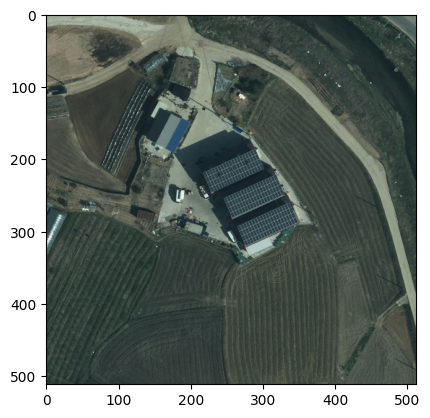

In [ ]:
plt.imshow(img.permute(1, 2, 0)) # plt.imshow(img.numpy().transpose((1,2,0)))

In [ ]:
target['masks'].shape, target['masks'].size(dim=0), target['masks'][0,:,:].shape, target['masks'].shape[1:]

(torch.Size([3, 512, 512]), 3, torch.Size([512, 512]), torch.Size([512, 512]))

In [ ]:
np.zeros(target['masks'].shape[1:]).shape

(512, 512)

In [ ]:
type(target['masks'])

torch.Tensor

In [ ]:
output['masks'].shape, output['masks'].squeeze(axis=1).shape

((9, 1, 512, 512), (9, 512, 512))

In [ ]:
keep = output['scores'] > 0.5
keep

array([ True,  True,  True,  True, False, False, False, False, False])

In [ ]:
predict = output['masks'].squeeze(axis=1)[keep]
predict.shape, type(predict)

((4, 512, 512), numpy.ndarray)

In [ ]:
img.shape, type(img)

(torch.Size([3, 512, 512]), torch.Tensor)

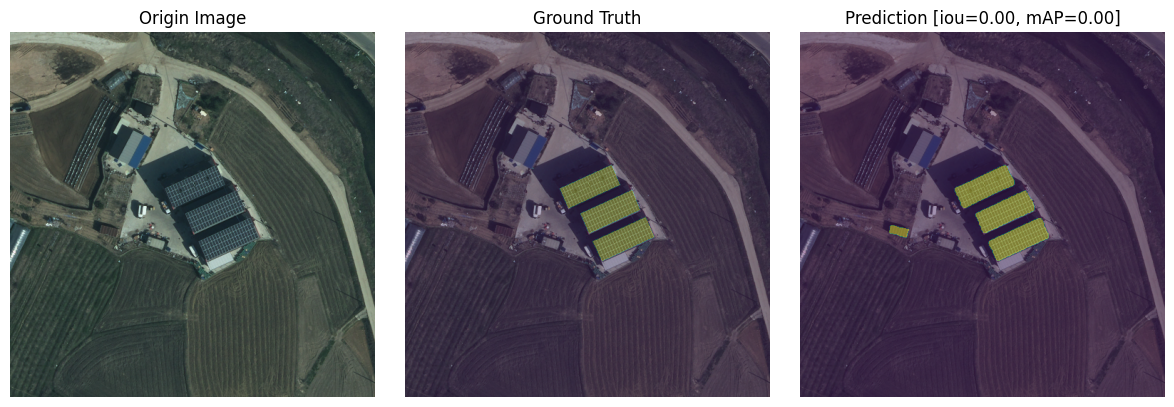

In [ ]:
# targ_masks = target['masks']
# pred_masks = output['masks'].squeeze(axis=1)[keep]
def save_result_image_with_mask(img_id, img, target_masks, predict_masks, iou=0., mAP=0.):
    """
    Params
     @img: 원본 이미지, shape=(3, 512, 512), type=torch.Tensor
     @target_masks: ground truth mask, shape=(N, 512, 512), type=torch.Tensor
     @predict_masks: prediction mask, shape=(N, 512, 512), type=numpy.ndarray
    """
    plt.figure(figsize=(12,4))

    image = img.numpy().transpose((1,2,0))
    plt.subplot(1, 3, 1)
    plt.imshow(image) # permute: 변경하다, 바꾸다; 순서를 바꾸다
    plt.title(f'Origin Image No.{img_id}')
    plt.axis('off')

    all_targ_masks = np.zeros(target_masks.shape[1:])
    for mask in target_masks:
        all_targ_masks = np.logical_or(all_targ_masks, mask)
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(all_targ_masks, alpha=0.3)
    plt.title('Ground Truth')
    plt.axis('off')

    all_pred_masks = np.zeros(predict_masks.shape[1:])
    for mask in predict_masks:
        all_pred_masks = np.logical_or(all_pred_masks, mask > MASK_THRESHOLD)
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(all_pred_masks, alpha=0.4)
    plt.title(f'Prediction [iou={iou:.2f}, mAP={mAP:.2f}]')
    plt.axis('off')

    plt.savefig(f'result.png', bbox_inches='tight', pad_inches=0.1)
    plt.tight_layout()
    plt.show()

save_result_image_with_mask(img, target['masks'], predict)

In [ ]:
test_dataset.catid_to_name

{1: 'Building', 2: 'Ground', 3: 'Water'}

In [ ]:
(np.random.random((1, 3))*0.6+0.4).tolist()[0],[random.randint(0, 255) for _ in range(3)],np.random.randint(0, 256, size=3)

([0.5303597128445415, 0.72910069036539, 0.911052761513678],
 [181, 99, 213],
 array([104,  87,  34]))

In [ ]:
np.random.randint(0, 256, size=3).tolist()

[75, 148, 23]

In [ ]:
img_id = target['image_id'].item()
img_id

0

In [ ]:
target['masks'][0].numpy().shape

(512, 512)

In [ ]:
from skimage import measure

contours = measure.find_contours(target['masks'][0].numpy(), level=0.5)
contours[0].shape

(295, 2)

In [ ]:
y, x = contours[0][0]
y, x

(247.5, 229.0)

In [ ]:
contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours[0]:
    print(contour)
    print(contour.flatten())
    print(contour.flatten().tolist())
    break

[[333 261]]
[333 261]
[333, 261]


In [ ]:
segmentation_coords = [contour.flatten().tolist() for contour in contours[0]]
len(segmentation_coords), len(segmentation_coords[0])

(153, 2)

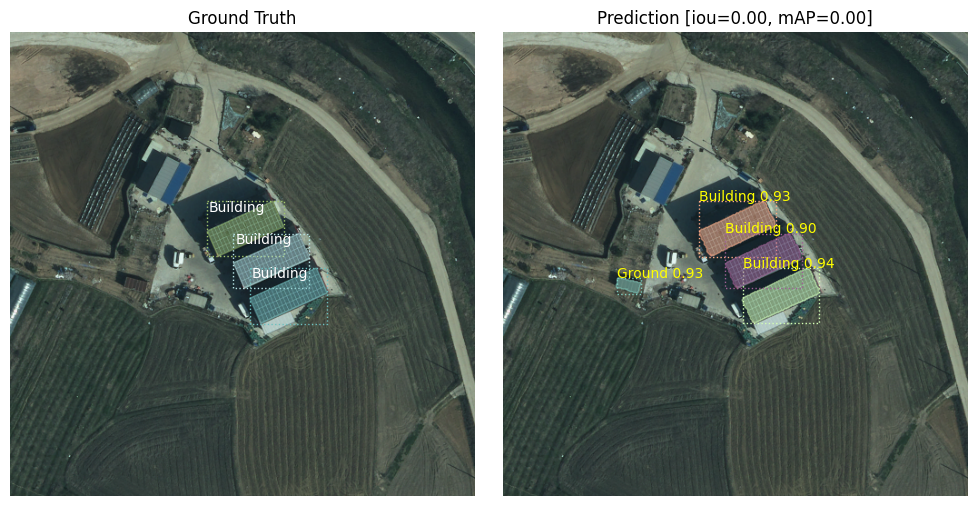

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

categoreis = test_dataset.catid_to_name

def convert_to_poly_pairs(seg):
    if isinstance(seg, list):
        return np.array(seg).reshape(int(len(seg)/2), 2)
    else:
        binary_mask = seg > 0.5
        contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        return [contour.flatten().tolist() for contour in contours[0]]
        # contours = measure.find_contours(seg, level=0.5)[0]
        # return [(x, y) for y, x in contours]

def save_result_image_with_sagment(coco, img_id, img, target, predict, iou=0., mAP=0.):
    image = img.numpy().transpose(1, 2, 0)
    _, axs = plt.subplots(1, 2, figsize=(10,5))

    # Ground Truth
    target_anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
    axs[0].imshow(image)
    for ann in target_anns:
        c = (np.random.random((1, 3))*0.6+0.34).tolist()[0]
        x, y, w, h = ann['bbox']
        axs[0].add_patch(
            Rectangle((x, y), w, h, edgecolor=c, facecolor='none', linewidth=1, linestyle=':')
        )
        # Polygon(xy, closed: bool = True, **kwargs: Any) -> None
        # *xy* is a numpy array with shape Nx2.
        xy_pairs = convert_to_poly_pairs(ann['segmentation'])
        axs[0].add_patch(Polygon(xy_pairs, edgecolor=c, facecolor=c, alpha=0.4))
        axs[0].text(x+2, y+11, categoreis[ann['category_id']], fontsize=10, color='white')
    axs[0].set_title('Ground Truth')
    axs[0].axis('off')


    # Prediction
    axs[1].imshow(image)
    for bbox, mask, label, score in zip(predict['boxes'], predict['masks'], predict['labels'], predict['scores']):
        c = (np.random.random((1, 3))*0.7+0.3).tolist()[0]
        x1, y1, x2, y2 = bbox
        axs[1].add_patch(
            Rectangle((x1, y1), x2-x1, y2-y1, edgecolor=c, facecolor='none', linewidth=1, linestyle=':')
        )
        xy_pairs = convert_to_poly_pairs(mask[0])
        axs[1].add_patch(Polygon(xy_pairs, edgecolor=c, facecolor=c, alpha=0.5))
        axs[1].text(x1, y1-1, f'{categoreis[label]} {score:.2f}', fontsize=10, color='yellow')
    axs[1].set_title(f'Prediction [iou={iou:.2f}, mAP={mAP:.2f}]')
    axs[1].axis('off')

    plt.savefig(f'result.png', bbox_inches='tight', pad_inches=0.1)
    plt.tight_layout()
    plt.show()

save_result_image_with_sagment(test_coco, target['image_id'].item(), img, target, predict)

In [ ]:
binary_mask = output['masks'].squeeze(axis=1)[0] > 0.5
mask_area = np.sum(binary_mask)
mask_area

2604

In [ ]:
mask_area = np.sum(output['masks'].squeeze(axis=1)[0])
mask_area

2599.347

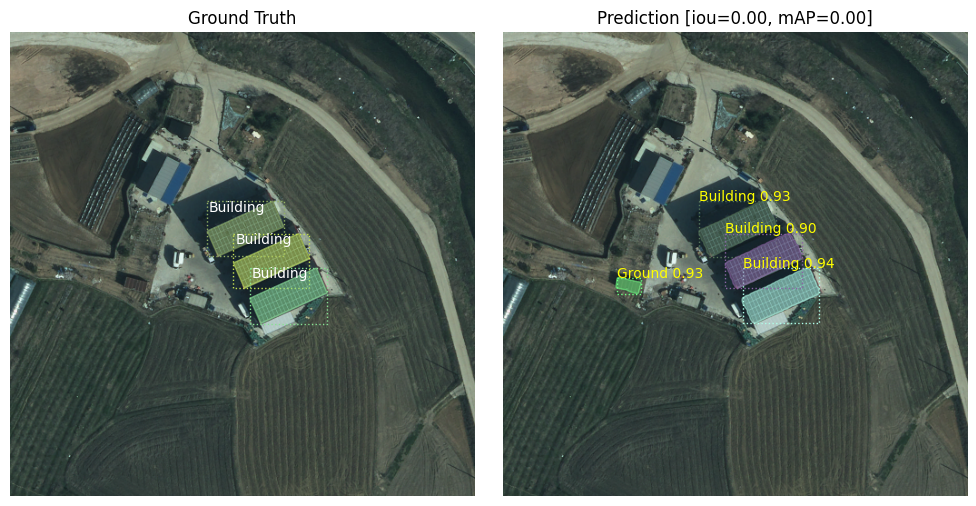

In [ ]:
from skimage import measure

categoreis = test_dataset.catid_to_name

def convert_to_poly_pairs(seg):
    if isinstance(seg, list):
        return np.array(seg).reshape(int(len(seg)/2), 2)
    else:
        contours = measure.find_contours(seg, level=0.5)[0]
        return [(x, y) for y, x in contours]

def save_result_image_with_sagment(coco, img_id, img, target, predict, iou=0., mAP=0.):
    image = img.numpy().transpose(1, 2, 0)
    _, axs = plt.subplots(1, 2, figsize=(10,5))

    # Ground Truth
    target_anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
    axs[0].imshow(image)
    for bbox, ann, label in zip(target['boxes'], target_anns, target['labels']):
        c = (np.random.random((1, 3))*0.7+0.3).tolist()[0]
        x1, y1, x2, y2 = bbox
        axs[0].add_patch(
            Rectangle((x1, y1), x2-x1, y2-y1, edgecolor=c, facecolor='none', linewidth=1, linestyle=':')
        )
        xy_pairs = convert_to_poly_pairs(ann['segmentation'])
        axs[0].add_patch(Polygon(xy_pairs, edgecolor=c, facecolor=c, alpha=0.5))
        axs[0].text(x1+2, y1+11, f"{categoreis[label]}", fontsize=10, color='white')
    axs[0].set_title('Ground Truth')
    axs[0].axis('off')


    # Prediction
    axs[1].imshow(image)
    for bbox, mask, label, score in zip(predict['boxes'], predict['masks'], predict['labels'], predict['scores']):
        c = (np.random.random((1, 3))*0.7+0.3).tolist()[0]
        x1, y1, x2, y2 = bbox
        axs[1].add_patch(
            Rectangle((x1, y1), x2-x1, y2-y1, edgecolor=c, facecolor='none', linewidth=1, linestyle=':')
        )
        xy_pairs = convert_to_poly_pairs(mask[0])
        axs[1].add_patch(Polygon(xy_pairs, edgecolor=c, facecolor=c, alpha=0.5))
        axs[1].text(x1, y1-1, f'{categoreis[label]} {score:.2f}', fontsize=10, color='yellow')
    axs[1].set_title(f'Prediction [iou={iou:.2f}, mAP={mAP:.2f}]')
    axs[1].axis('off')

    plt.savefig(f'result.png', bbox_inches='tight', pad_inches=0.1)
    plt.tight_layout()
    plt.show()

save_result_image_with_sagment(test_coco, target['image_id'].item(), img, target, predict)